# AT-BLSTM for CCAT50

In [1]:
# Start GPU
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from __future__ import print_function
import os
import re
import sys
import pandas as pd
import numpy as np

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
import pandas as pd
import keras.layers as layers
import tensorflow as tf
import tensorflow_hub as hub
import pydot
import itertools
import h5py
import keras.callbacks
import tensorflow as tf
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.regularizers import l2
from AdamW import AdamW
from SGDW import SGDW
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, Flatten, merge
from keras.models import Model
from keras.callbacks import CSVLogger
from keras.layers import Conv1D, MaxPooling1D,AveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.layers import TimeDistributed, Bidirectional, Lambda
from keras.layers import Layer
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [5]:
from keras.models import Model
from keras.utils import plot_model
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

In [6]:
# Load nltk 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.classify.scikitlearn import SklearnClassifier
%matplotlib inline

In [7]:
batch_size = 128 
maxlen = 512
max_sentences = 15
w_l2 = 1e-4
nb_classes = 50

In [8]:
def preProcessText(text):
    #str(tweet.encode('utf-8')) 
    str(text)
    #Replace all words preceded by '@' with 'USER_NAME'
    text  = re.sub(r'@[^\s]+', 'USER_NAME', text)  
    #Replace all url's with 'URL'
    text  = re.sub(r'www.[^\s]+ | http[^\s]+',' URL ', text)
    #Replace all hashtags with the word
    text  = text.strip('#')
    #Replace words with long repeated characters with the shorter form
    text  = re.sub(r'(.)\1{2,}', r'\1', text)
    #Remove any extra white space
    text = re.sub(r'[\s]+', ' ', text)
    return text

In [9]:
def striphtml(s):
    p = re.compile(r'<.*?>')
    return p.sub("", str(s))
def clean(s):
    return re.sub(r'[^\x00-\x7f]', r'', s)

In [10]:
# Load dataset now
datasource = '../../data/ccat50/'
ccat50_train = pd.read_csv(datasource + 'cleantrainaugmented.csv')
ccat50_test = pd.read_csv(datasource + 'cleantest.csv', index_col=0)

In [11]:
ccat50_train.head(3)

,text,label,augmented
0,china has moved step further from its recent r...,JaneMacartney,china has proceed step further from its recent...
1,the family of detained chinese dissident wang ...,JaneMacartney,the family of detained chinese dissident wang ...
2,the watchdogs of china ruling communist party ...,JaneMacartney,the watchdogs of china find communist party ac...


In [12]:
ccat50_train['text'] = ccat50_train['text'].apply(preProcessText)
ccat50_train['augmented'] = ccat50_train['augmented'].apply(preProcessText)

In [13]:
trainx = pd.concat([ccat50_train['text'],ccat50_train['augmented']],ignore_index=True)
trainy = pd.concat([ccat50_train['label'],ccat50_train['label']],ignore_index=True)
# convert to dataframe
trainx = pd.DataFrame(trainx,columns=['text'])
trainy = pd.DataFrame(trainy,columns=['label'])

In [14]:
txt = ''
docs = []
sentences = []
labels = []
for cont, label in zip(trainx.text, trainy.label):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', clean(striphtml(cont)))
    sentences = [sent.lower() for sent in sentences]
    docs.append(sentences)
    labels.append(label)

In [15]:
num_sent = []
for doc in docs:
    num_sent.append(len(doc))
    for s in doc:
        txt += s

In [16]:
chars = set(txt)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 29


In [17]:
print (len(docs)), print(len(chars))

5000
29


(None, None)

In [18]:
print('Doing One hot encoding for training sample and targets:')
x = np.ones((len(docs), max_sentences, maxlen), dtype=np.int64) * -1
y = np.array(labels)
for i, doc in enumerate(docs):
    for j, sentence in enumerate(doc):
        if j < max_sentences:
            for t, char in enumerate(sentence[-maxlen:]):
                x[i, j, (maxlen - 1 - t)] = char_indices[char]             

Doing One hot encoding for training sample and targets:


In [19]:
print('Sample Training X_train:{}'.format(x[0]))

Sample Training X_train:[[23 16 21 ... 28 13  5]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
# binary encode
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)
print('training label:', y.shape)

training label: (5000, 50)


/home/ds-nlp/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
print(y.shape)

(5000, 50)


# Test dataset

In [22]:
test_docs = []
sent = []
test_labels = []
for cont, label in zip(ccat50_test.text, ccat50_test.label):
    sent = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', 
                    clean(striphtml(cont)))
    sent = [sent.lower() for sent in sent]
    test_docs.append(sent)
    test_labels.append(label)

In [23]:
print('Doing One hot encoding for testing sample and targets:')
x_test = np.ones((len(test_docs), max_sentences, maxlen), dtype=np.int64) * -1
print(x_test.shape)
y_test = np.array(test_labels)
for i, doc in enumerate(test_docs):
    for j, sentence in enumerate(doc):
        if j < max_sentences:
            for t, char in enumerate(sentence[-maxlen:]):
                #print(t)
                x_test[i, j, (maxlen - 1 - t)] = char_indices[char]             

Doing One hot encoding for testing sample and targets:
(2500, 15, 512)


In [24]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_test)
# binary encode
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_test = onehot_encoder.fit_transform(integer_encoded)
print('training label:', y_test.shape)

training label: (2500, 50)


/home/ds-nlp/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Attention layer

In [25]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [26]:
class AttentionWithContext(Layer):
   
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)
        weighted_input = x * a
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), a]
        else:
            return K.sum(weighted_input, axis=1)
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# Precision, Recall and F-Score Script

In [27]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Tensor board

In [28]:
# tensorbd_dir = 'drive/My Drive/Colab Notebooks/imbd62/'
model_save_dir = '../../save_models/ccat50/'
tensorboard = TensorBoard(log_dir=model_save_dir+'./ccat50_SGDW_logs',
                         histogram_freq=0, 
                          write_graph=True, 
                         write_images=True)

# Callback

In [29]:
reduce_lr_adam = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                                   patience=5,min_lr=1e-4)
reduce_lr_sgd = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,patience=5, min_lr=1e-5)

# Earlystop and others

In [30]:
# EarlyStopping
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,verbose=1,
                                          mode='auto')
num_epochs = 100
#checkpointer
checkpointer = ModelCheckpoint(model_save_dir+'ccat50_adamw_SGDW.hdf5', 
                               monitor='val_acc', 
                               verbose=1, save_best_only=True,
                               mode='max')
# CSV logger keras
csv_logger = CSVLogger(model_save_dir+'ccat50_adamw_SGDW.csv', 
                       append=True, separator=';')

# Convolutional layer with filter, windows and pooling

In [31]:
# Convolutional layer parameter
filter_length = [7, 3, 3]
nb_filter = [512, 256,128]
pool_length = 2

In [32]:
# sentence input
in_sentence = Input(shape=(maxlen,),
                    dtype='int64',name='main_input1')
# document input
document = Input(shape=(max_sentences, maxlen), 
                 dtype='int64',name='main_input2')

In [33]:
def binarize(x, sz=30):
    return tf.to_float(tf.one_hot(x, sz, on_value=1, off_value=0, axis=-1))
def binarize_outshape(in_shape):
    return in_shape[0], in_shape[1], 30

In [34]:
embedded = Lambda(binarize, output_shape=binarize_outshape, 
                  name='embed_input')(in_sentence)

Instructions for updating:
Use `tf.cast` instead.


In [35]:
from keras import initializers
from keras.initializers import glorot_normal, normal

# Encoding Layer

In [36]:
# embedded: encodes sentence
for i in range(len(nb_filter)):
    embedded = Conv1D(filters=nb_filter[i],
                      kernel_size=filter_length[i],
                      padding='valid',
                      activation='relu',
                      kernel_initializer='glorot_normal',
                      strides=1)(embedded)

embedded = Dropout(0.3)(embedded)
embedded = MaxPooling1D(pool_size=pool_length)(embedded)

bi_lstm_sent = \
    Bidirectional(LSTM(128, return_sequences=False))(embedded)
sent_encode = Dropout(0.3)(bi_lstm_sent)
encoder = Model(inputs=in_sentence, outputs=sent_encode)
encoder.summary()




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input1 (InputLayer)     (None, 512)               0         
_________________________________________________________________
embed_input (Lambda)         (None, 512, 30)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 506, 512)          108032    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 504, 256)          393472    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 502, 128)          98432     
_________________________________________________________________
dropout_1 (Dropout)          (None, 502, 128)          0         
_____

# Decoder Layer

In [37]:
def build_cnn():    
    encoded = TimeDistributed(encoder)(document)
    # encoded: sentences to bi-lstm for document encoding 
    b_lstm_doc = \
        Bidirectional(LSTM(128, return_sequences=False))(encoded)
#     output = AttentionWithContext()(b_lstm_doc)
    output = Dropout(0.7)(b_lstm_doc)
    output = Dense(1024, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(nb_classes, activation='softmax')(output)
    model = Model(inputs=document, outputs=output)
    model.summary()
    return model

# Training with AdamW 
  * from: https://github.com/shaoanlu/AdamW-and-SGDW

In [34]:
# Adam parameter
model_ccat50 = build_cnn()
b, B, T = batch_size, x.shape[0], num_epochs
wd = 0.005 * (b/B/T)**0.5
model_ccat50.compile(loss='categorical_crossentropy',
                optimizer=AdamW(weight_decay=wd),metrics=['accuracy',f1])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 256)           863104    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5125

In [39]:
# save model
model_ccat50.save_weights(model_save_dir+"saved_ccat50_model.h5")

In [40]:
k = 5
scores = []
num_validation_sample = len(x)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x[:i * num_validation_sample],
                x[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y[:i * num_validation_sample],
                y[(i + 1) * num_validation_sample:]], axis=0)
    
    history_ccat50_atten = model_ccat50.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,verbose=1,
                               callbacks=[reduce_lr_adam,earlystop,csv_logger,checkpointer])

-----------------------------
Processing fold # 0
-----------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4000 samples, validate on 1000 samples
Epoch 1/80
4000/4000 [==============================] - 296s 74ms/step - loss: 3.8880 - acc: 0.0227 - f1: 0.0000e+00 - val_loss: 4.1968 - val_acc: 0.0000e+00 - val_f1: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to ../../save_models/ccat50/ccat50_adamw.hdf5
Epoch 2/80
4000/4000 [==============================] - 291s 73ms/step - loss: 3.7744 - acc: 0.0398 - f1: 4.8485e-04 - val_loss: 4.1386 - val_acc: 0.0000e+00 - val_f1: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/80
4000/4000 [==============================] - 291s 73ms/step - loss: 3.4722 - acc: 0.0877 - f1: 0.0456 - val_loss: 3.9196 - val_acc: 0.0000e+00 - val_f1: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/80
4000/4000 [=========

In [41]:
#Print average acc
average_acc = np.mean(history_ccat50_atten.history['acc'])
print(average_acc)
print("------------")
#Print average val_acc
average_val_acc = np.mean(history_ccat50_atten.history['val_acc'])
print(average_val_acc)
print("------------")

0.9930499999999999
------------
1.0
------------


In [42]:
#Print average loss
average_loss = np.mean(history_ccat50_atten.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_ccat50_atten.history['val_loss'])
print(average_val_loss)
print("------------")

0.0225146318156505
------------
2.2205487702967734e-05
------------


In [43]:
#Print average f1-score
average_f1 = np.mean(history_ccat50_atten.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_ccat50_atten.history['val_f1'])
print(average_val_f1)
print("------------")

0.99302419257164
------------
1.0
------------


In [44]:
# Evaluate the Model on the 20% Validation Dataset
score =  model_ccat50.evaluate(val_data, val_lab, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

1000/1000 [==============================] - 19s 19ms/step
Test loss: 2.0834818082676065e-05
Test accuracy: 1.0


In [45]:
# Evaluate the Model on the 20% Test Dataset
scorev =  model_ccat50.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', scorev[0])
print('Test accuracy:', scorev[1])

2500/2500 [==============================] - 48s 19ms/step
Test loss:  10.779514399719238
Test accuracy: 0.194


In [46]:
prediction_value = model_ccat50.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
y_test_integer = np.argmax(y_test, axis=1)

In [47]:
# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_integer, predict_class))

              precision    recall  f1-score   support

           0       0.09      0.10      0.10        50
           1       0.33      0.30      0.31        50
           2       0.10      0.04      0.06        50
           3       0.04      0.12      0.06        50
           4       0.41      0.30      0.34        50
           5       0.03      0.06      0.04        50
           6       0.06      0.08      0.07        50
           7       0.11      0.06      0.08        50
           8       0.09      0.04      0.06        50
           9       0.67      0.24      0.35        50
          10       0.15      0.20      0.17        50
          11       0.04      0.10      0.06        50
          12       0.07      0.14      0.09        50
          13       0.24      0.18      0.21        50
          14       0.02      0.02      0.02        50
          15       1.00      0.94      0.97        50
          16       0.43      0.18      0.25        50
          17       0.03    

# Plot

In [4]:
modelsource = '../../save_models/ccat50/'
df_ccat50 = pd.read_csv(modelsource +'/ccat50_adamw.csv',engine='python',sep=';')
# df_movies.to_excel(modelsource+'/imbd622.xlsx',engine='xlsxwriter')

In [5]:
df_ccat50.head(100)

,epoch,acc,f1,loss,lr,val_acc,val_f1,val_loss
0,0,0.02575,0.000000,3.904880,0.001000,0.000,0.000000,4.145324
1,1,0.01900,0.000000,3.891559,0.001000,0.000,0.000000,4.090615
2,2,0.02175,0.000000,3.884626,0.001000,0.000,0.000000,4.175266
3,3,0.02250,0.000000,3.877156,0.001000,0.000,0.000000,4.202045
4,4,0.02350,0.000000,3.872223,0.001000,0.000,0.000000,4.239463
5,0,0.02300,0.000000,3.903327,0.001000,0.000,0.000000,4.083933
6,1,0.02525,0.000000,3.885838,0.001000,0.000,0.000000,4.101827
7,2,0.02350,0.000000,3.879899,0.001000,0.000,0.000000,4.166552
8,3,0.02175,0.000000,3.873158,0.001000,0.000,0.000000,4.250594
9,0,0.02175,0.000000,3.890564,0.001000,0.000,0.000000,4.262088


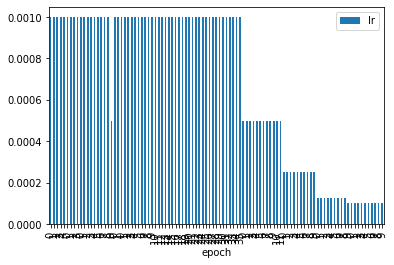

In [50]:
df_ccat50.plot('epoch','lr',kind='bar')

# Training accuracy and validate 4 CCAT50

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 1, 'AT-BLSTM model accuracy for CCAT50')

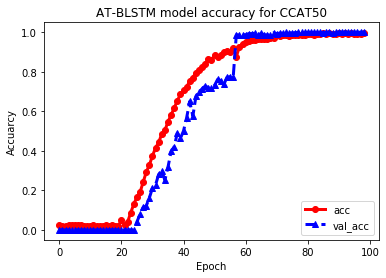

In [52]:
plt.plot(df_ccat50.index, df_ccat50['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_ccat50.index, df_ccat50['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'ccat50_acc.png')
plt.title('AT-BLSTM model accuracy for CCAT50')

# Training loss and validate 4 CCAT50

Text(0.5, 1, 'AT-BLSTM model loss for CCAT50')

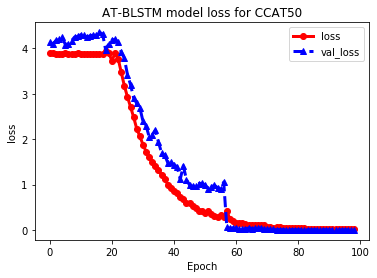

In [53]:
plt.plot(df_ccat50.index, df_ccat50['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_ccat50.index, df_ccat50['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'ccat50_loss.png')
plt.title('AT-BLSTM model loss for CCAT50')

# F1-Score

Text(0.5, 1, 'AT-BLSTM model F-score for CCAT50')

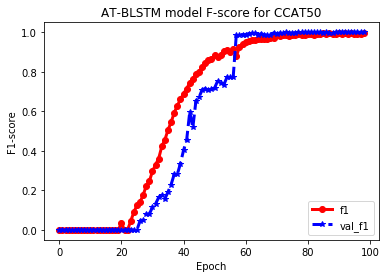

In [54]:
plt.plot(df_ccat50.index, df_ccat50['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_ccat50.index, df_ccat50['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'ccat50_F1-score.png')
plt.title('AT-BLSTM model F-score for CCAT50')

# Model with cross-validation

# Training SGDW

In [40]:
from keras.optimizers import SGD
model_SGDW = build_cnn()
b, B, T = batch_size, x.shape[0], num_epochs
wd = 0.0025 * (b/B/T)**0.5
model_SGDW.compile(loss='categorical_crossentropy',
                 optimizer=SGDW(weight_decay=wd, momentum=0.9),
                 metrics=['accuracy',f1])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input2 (InputLayer)     (None, 15, 512)           0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 256)           863104    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5125

In [41]:
# save model
model_SGDW.save_weights(model_save_dir+"saved_IMBD62_model_SGDW.h5")

In [43]:
k = 5
scores = []
num_validation_sample = len(x)//k
for i in range(k):
    print("-----------------------------")
    print('Processing fold #', i)
    print("-----------------------------")
    val_data = x[i * num_validation_sample: (i + 1) * num_validation_sample]
    val_lab  = y[i * num_validation_sample: (i + 1) * num_validation_sample]
    
    parttial_train_X_data = np.concatenate(
                [x[:i * num_validation_sample],
                x[(i + 1) * num_validation_sample:]], axis=0)
    
    parttial_train_X_label = np.concatenate(
                [y[:i * num_validation_sample],
                y[(i + 1) * num_validation_sample:]], axis=0)
    
    history_imbd62_SGDW = model_SGDW.fit(parttial_train_X_data, parttial_train_X_label, 
                               validation_data=(val_data,val_lab),
                               batch_size=batch_size,epochs=num_epochs,verbose=1,
                               callbacks=[reduce_lr_sgd,earlystop,csv_logger,checkpointer])

-----------------------------
Processing fold # 0
-----------------------------
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 286s 71ms/step - loss: 3.9096 - acc: 0.0208 - f1: 0.0000e+00 - val_loss: 3.9450 - val_acc: 0.0000e+00 - val_f1: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to ../../save_models/ccat50/ccat50_adamw_SGDW.hdf5
Epoch 2/100
4000/4000 [==============================] - 280s 70ms/step - loss: 3.9004 - acc: 0.0263 - f1: 0.0000e+00 - val_loss: 3.9936 - val_acc: 0.0000e+00 - val_f1: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/100
4000/4000 [==============================] - 279s 70ms/step - loss: 3.8927 - acc: 0.0238 - f1: 0.0000e+00 - val_loss: 4.0402 - val_acc: 0.0000e+00 - val_f1: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/100
4000/40

# Result

In [ ]:
#Print average acc
average_acc = np.mean(history_imbd62_SGDW.history['acc'])
print(average_acc)
print("------------")
#Print average val_acc
average_val_acc = np.mean(history_imbd62_SGDW.history['val_acc'])
print(average_val_acc)
print("------------")

In [ ]:
#Print average loss
average_loss = np.mean(history_imbd62_SGDW.history['loss'])
print(average_loss)
print("------------")
#Print average val_loss
average_val_loss = np.mean(history_imbd62_SGDW.history['val_loss'])
print(average_val_loss)
print("------------")

In [ ]:
#Print average f1-score
average_f1 = np.mean(history_imbd62_SGDW.history['f1'])
print(average_f1)
print("------------")
#Print average val_f1-score
average_val_f1 = np.mean(history_imbd62_SGDW.history['val_f1'])
print(average_val_f1)
print("------------")

In [ ]:
# Evaluate the Model on the 20% Test Dataset
scorev =  model_SGDW.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', scorev[0])
print('Test accuracy:', scorev[1])

In [ ]:
prediction_value = model_SGDW.predict(x_test)
predict_class = np.argmax(prediction_value, axis=-1)
y_test_integer = np.argmax(y_test, axis=1)

# Detailed analysis
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_integer, predict_class))

In [ ]:
modelsource = '../../save_models/imbd62/'
df_movies_SGD = pd.read_csv(modelsource +'/imbd62_SGDW.csv',
                        engine='python',
                        sep=';')

In [ ]:
df_movies_SGD.head(3)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
plt.plot(df_movies.index, df_movies['acc'], 'go-', color='red', label= 'acc',linewidth=3)
plt.plot(df_movies.index, df_movies['val_acc'], '--^', color='blue',label= 'val_acc',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuarcy')
plt.savefig(modelsource + 'imdb62_SGDW_acc.png')
plt.title('AT-BLSTM model accouracy for IMBD62')

In [ ]:
plt.plot(df_movies.index, df_movies['loss'], 'go-', color='red', label= 'loss',linewidth=3)
plt.plot(df_movies.index, df_movies['val_loss'], '--^', color='blue',label= 'val_loss',linewidth=3)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig(modelsource + 'imdb62_SGDW_loss.png')
plt.title('AT-BLSTM model loss for IMBD62')

In [ ]:
plt.plot(df_movies.index, df_movies['f1'], 'go-', color='red', label= 'f1',linewidth=3)
plt.plot(df_movies.index, df_movies['val_f1'], '--*', color='blue',label= 'val_f1',linewidth=3)
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.savefig(modelsource + 'imdb62_SGDW_F1-score.png')
plt.title('AT-BLSTM model F-score for IMBD62')

# SGD without earlystop

In [ ]:
model_SGD = build_cnn()

In [ ]:
model_SGD.compile(loss='categorical_crossentropy',
                 optimizer=SGD(momentum=0.9),
                  metrics=['accuracy',f1])

In [ ]:
# save model
model_SGD.save_weights(model_save_dir+"saved_IMBD62_SGD_model.h5")
history_imbd62_atten = model_SGD.fit(x_train, y_train, 
                            validation_data=(x_test,y_test),
                            batch_size=512,epochs=80,
                            verbose=1,callbacks=[reduce_lr_adam,csv_logger])